# Age and Gender Detection

## 1. Dataset Loading

### 1.1 Load Dataset & Inspect CSV

In [1]:
import pandas as pd

CSV_PATH = "/kaggle/input/ageutk/ageutk_full.csv"
IMG_DIR = "/kaggle/input/ageutk/UTKFace/UTKFace/UTKFace"

df = pd.read_csv(CSV_PATH)
df.head()


,files,age,gender
0,26_0_2_20170104023102422.jpg.chip.jpg,26,0
1,22_1_1_20170112233644761.jpg.chip.jpg,22,1
2,21_1_3_20170105003215901.jpg.chip.jpg,21,1
3,28_0_0_20170117180555824.jpg.chip.jpg,28,0
4,17_1_4_20170103222931966.jpg.chip.jpg,17,1


## 2. Basic Dataset Validation

### 2.1 Check size, null values, and gender distribution

In [2]:
print("Total samples:", len(df))
print(df.isnull().sum())
print(df['gender'].value_counts())

Total samples: 23168
files     0
age       0
gender    0
dtype: int64
gender
0    12208
1    10960
Name: count, dtype: int64


### 2.2 Age Sanity Checks


In [3]:
print("Min age:", df['age'].min())
print("Max age:", df['age'].max())

Min age: 1
Max age: 80


### 3.Image Loading & Preprocessing

### 3.1 Image Loader Function

In [4]:
IMG_SIZE = 128

def load_and_preprocess(img_name):
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    
    if img is None:
        return None
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

### 3.2 Build Clean Dataset

In [5]:
def generator(df, batch_size=32, is_train=True):
    while True:
        if is_train:
            df = df.sample(frac=1)  # shuffle
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            images, ages, genders = [], [], []
            for _, row in batch_df.iterrows():
                img = load_and_preprocess(row['files'])
                if img is None:
                    continue
                images.append(img)
                ages.append(row['age'])
                genders.append(row['gender'])
            if len(images) == 0:
                continue
            yield np.array(images, dtype=np.float32), (
                np.array(ages, dtype=np.float32),
                np.array(genders, dtype=np.float32)
            )


## 4. Train / Validation Split

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

## 5. Model Design

### 5.1 Import Libraries

In [20]:
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D,
    Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

### 5.2 Load Pretrained Backbone (MobileNetV2)

In [9]:
IMG_SIZE = 128

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

I0000 00:00:1766734467.355360      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 5.3 Build the Dual-Head Architecture

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

age_output = Dense(1, name="age")(x)
gender_output = Dense(1, activation="sigmoid", name="gender")(x)

### 5.4 Create and Compile the Model

In [11]:
model = Model(
    inputs=base_model.input,
    outputs=[age_output, gender_output]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "age": "mse",
        "gender": "binary_crossentropy"
    },
    metrics={
        "age": "mae",
        "gender": "accuracy"
    }
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 6. Initial Model Training

### 6.1 Define the Generator Function

In [22]:
BATCH_SIZE = 128

def generator(df, is_train=True):
    while True:
        if is_train:
            df = df.sample(frac=1) 
        for i in range(0, len(df), BATCH_SIZE):
            batch_df = df.iloc[i:i+BATCH_SIZE]
            images = []
            ages = []
            genders = []
            for _, row in batch_df.iterrows():
                img_path = os.path.join(IMG_DIR, row['files'])
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                if is_train:
                    img = tf.image.random_flip_left_right(img)
                images.append(img)
                ages.append(row['age'])
                genders.append(row['gender'])
            if len(images) == 0:
                continue
            yield (np.array(images, dtype=np.float32),
                   (np.array(ages, dtype=np.float32), np.array(genders, dtype=np.float32)))

output_signature = (
    tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
)

### 6.2 Create tf.data.Dataset from Generator 

In [23]:
train_ds = tf.data.Dataset.from_generator(
    lambda: generator(df_train, is_train=True),
    output_signature=output_signature
)

val_ds = tf.data.Dataset.from_generator(
    lambda: generator(df_val, is_train=False),
    output_signature=output_signature
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [24]:
steps_per_epoch = len(df_train) // BATCH_SIZE
validation_steps = len(df_val) // BATCH_SIZE

### 6.3 Callbacks

In [25]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6
    )
]


### 6.4 Train the Model

In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 536ms/step - age_loss: 148.4404 - age_mae: 9.2633 - gender_accuracy: 0.6446 - gender_loss: 0.6851 - loss: 149.1255 - val_age_loss: 141.0126 - val_age_mae: 8.8711 - val_gender_accuracy: 0.7168 - val_gender_loss: 0.5584 - val_loss: 141.5710 - learning_rate: 0.0010
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 414ms/step - age_loss: 146.0501 - age_mae: 9.1517 - gender_accuracy: 0.6475 - gender_loss: 0.6528 - loss: 146.6993 - val_age_loss: 137.9976 - val_age_mae: 8.7362 - val_gender_accuracy: 0.7257 - val_gender_loss: 0.5604 - val_loss: 138.5581 - learning_rate: 0.0010
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 415ms/step - age_loss: 137.6145 - age_mae: 8.8829 - gender_accuracy: 0.6611 - gender_loss: 0.6193 - loss: 138.4143 - val_age_loss: 134.5796 - val_age_mae: 8.6217 - val_gender_accuracy: 0.7281 - val_gender_loss: 0.5601 - val_loss: 135.1397 - learning_rate: 0.0010
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - age_loss: 136.8152 - a

### 6.5 Evaluate

In [28]:
model.evaluate(val_ds, steps=validation_steps)

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - age_loss: 120.9364 - age_mae: 8.1419 - gender_accuracy: 0.7366 - gender_loss: 0.5381 - loss: 121.4745


[123.8536376953125,
 123.31829071044922,
 0.5353336334228516,
 8.168700218200684,
 0.7406684160232544]

### 6.6 Plots

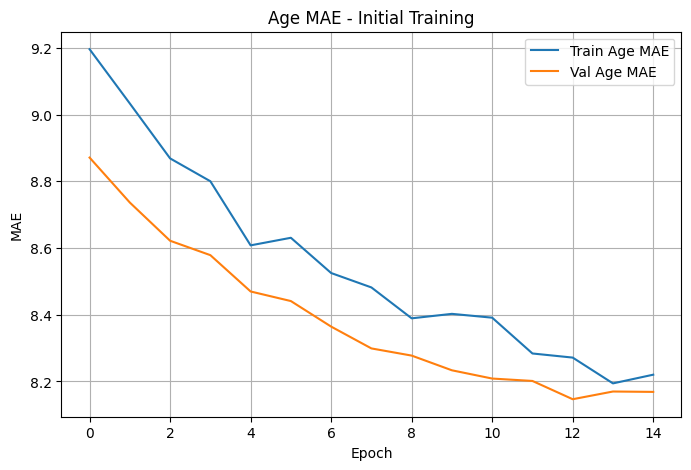

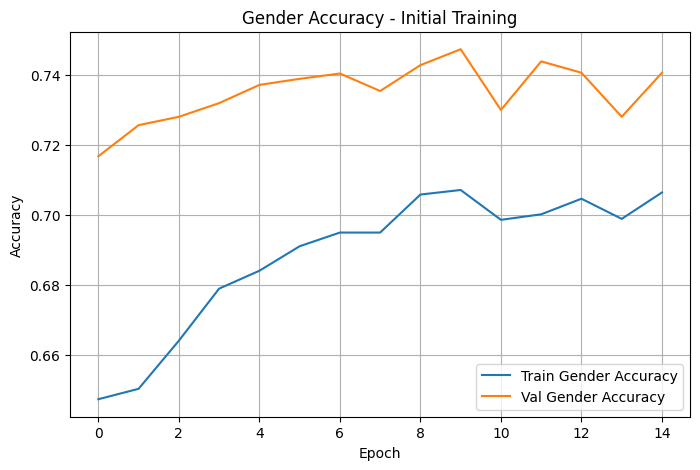

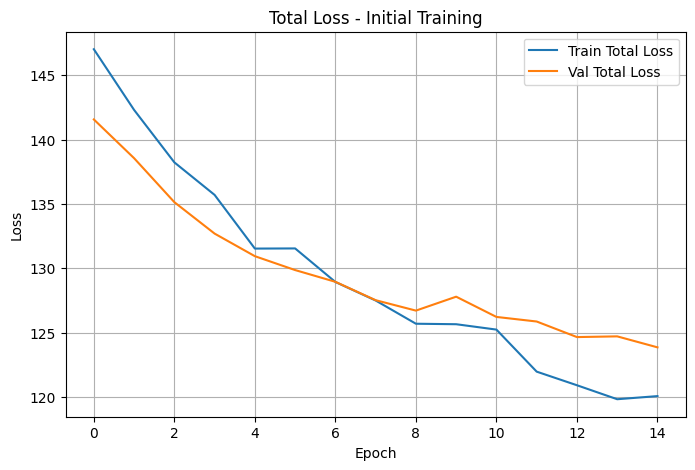

In [30]:
import matplotlib.pyplot as plt
import os

PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

plt.figure(figsize=(8,5))
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Val Age MAE')
plt.title('Age MAE - Initial Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, 'initial_training_age_mae.png'))
plt.show()
plt.close()

plt.figure(figsize=(8,5))
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Val Gender Accuracy')
plt.title('Gender Accuracy - Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, 'initial_training_gender_accuracy.png'))
plt.show()
plt.close()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title('Total Loss - Initial Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(PLOT_DIR, 'initial_training_total_loss.png'))
plt.show()
plt.close()
